In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

# Загрузка источников

In [2]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

Описание данных

1. client_id - идентификатор клиента
2. education - уровень образования
3. sex - пол заёмщика
4. age - возраст заёмщика
5. car	- флаг наличия автомобиля
6. car_type - флаг автомобиля-иномарки
7. decline_app_cnt	- количество отказанных прошлых заявок
8. good_work - флаг наличия «хорошей» работы
9. bki_request_cnt	- количество запросов в БКИ
10. home_address - категоризатор домашнего адреса
11. work_address - категоризатор рабочего адреса
12. income - доход заёмщика
13. foreign_passport - наличие загранпаспорта
14. default - наличие дефолта

In [3]:
print('Размерность тренировочного датасета:', train.shape)
display(train.head(5))
print('Размерность тестового датасета:', test.shape)
display(test.head(5))
print('Размерность валидационного датасета:', sample_submission.shape)
display(sample_submission.head(5))

Размерность тренировочного датасета: (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Размерность тестового датасета: (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


Размерность валидационного датасета: (24354, 2)


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


# Функции и полезности

In [4]:
#scatter plot
def scatter_plot (column):
    var = column
    data = pd.concat([train['default'], train[var]], axis=1)
    data.plot.scatter(x=var, y='default')

In [5]:
#distribution plot
def dist_plot(table, column, p_bin = 20):
    fig = plt.figure()
    axes = fig.add_axes([0,0,1,1])
    axes.hist(table[column], bins = p_bin, color='grey')
    axes.set_ylabel('Количество '+column)
    axes.set_xlabel(column)

In [6]:
def dist_iqr(column):
    IQR = train[column].quantile(0.75) - train[column].quantile(0.25)
    perc25 = train[column].quantile(0.25)
    perc75 = train[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25),
          '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR),
          "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    
    f=perc25 - 1.5*IQR
    l=perc75 + 1.5*IQR
    
    return f, l

In [7]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=column, 
                data=train.loc[train.loc[:, column].isin(train.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

# Обработка пропусков

In [8]:
train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

Единственное поле с пропусками на тренировочной выборке - education

In [9]:
test.isna().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

Аналогичная ситуация с тестовым датасетом

Посмотрим на реаспределение признака education в train/test датасетах 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='education', ylabel='count'>

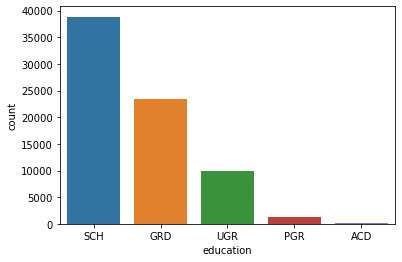

In [10]:
sns.countplot(train['education'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='education', ylabel='count'>

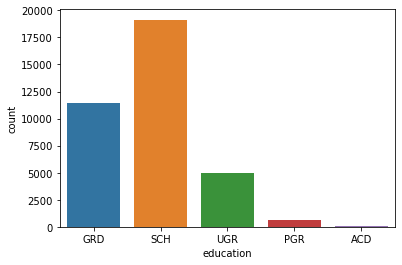

In [11]:
sns.countplot(test['education'])

В обоих случаях наиболее часто встречающимся значением является SCH. Заполним пропуски этим значением

In [12]:
train['education'].fillna('SCH', inplace=True)
test['education'].fillna('SCH', inplace=True)

# Обработка признаков, EDA

### Для начала обработаем признак app_data, приведя его к удобному формату

In [13]:
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)

In [14]:
display(train.head(5))
display(test.head(5))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,2014-03-22,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,2014-01-24,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,2014-03-23,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,2014-02-03,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,2014-02-04,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


## Для удобства разделим признаки на категории

In [15]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time','region_rating']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

## Посмотрим распределение числовых признаков в зависимости от целевой переменной

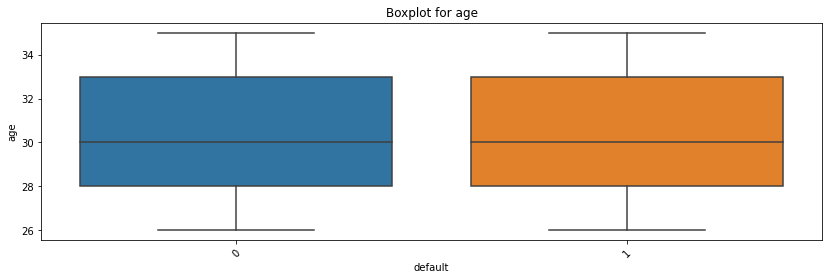

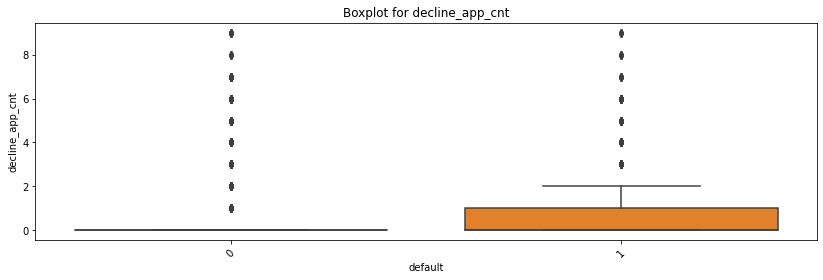

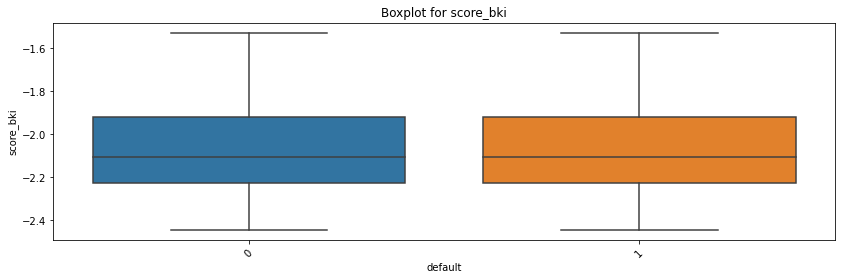

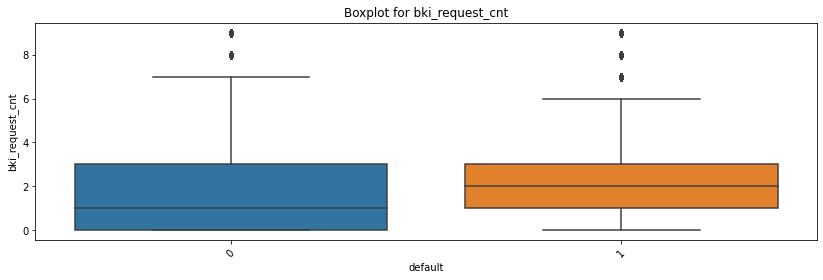

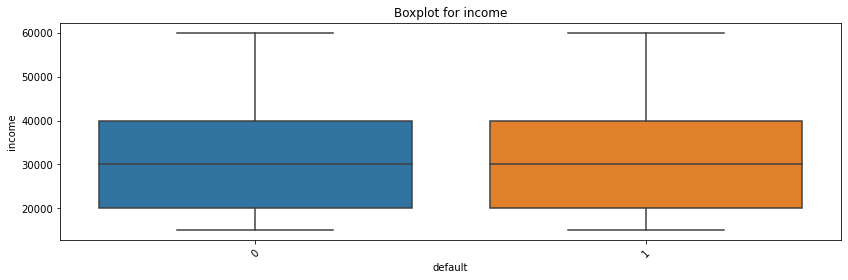

In [16]:
for col in num_cols:
    get_boxplot(col)

Из графиков выше видно:
1. У дефолтных клиентов количество отклоненных заявок выше.
2. Средний показатель числа запросов в БКИ у дефолтных клиентов выше. Присутствуют выбросы, которые нужно обработать.

### Удаляем выбросы из bki_request_cnt

In [17]:
d1, d2 = dist_iqr('bki_request_cnt')

25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].


In [18]:
train = train.loc[train['bki_request_cnt'].between(d1, d2)]

### Посмотрим на распределение числовых данных

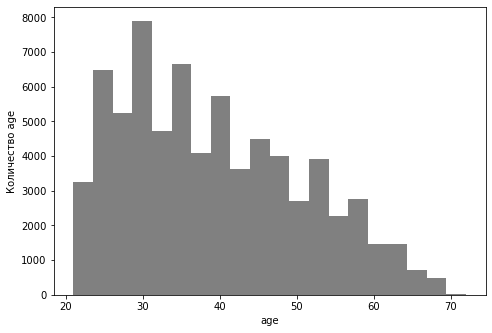

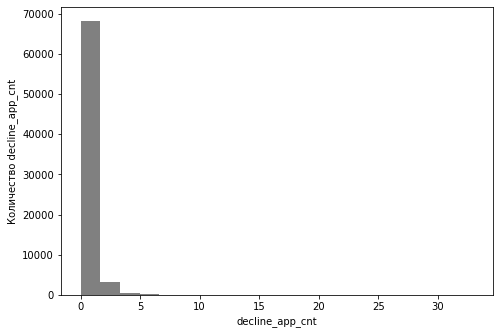

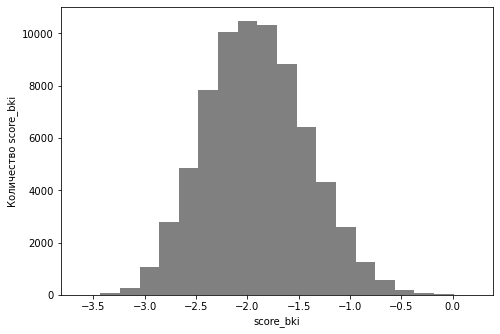

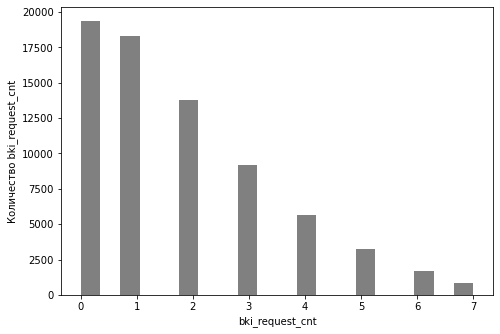

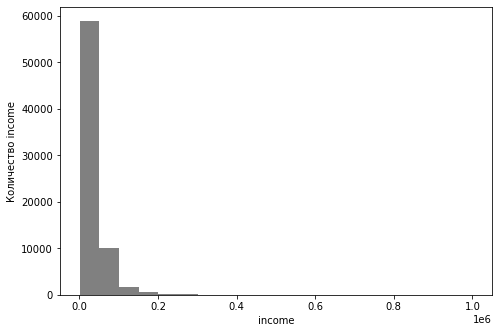

In [19]:
for col in num_cols:
    dist_plot(train, col)

По графикам видно, что распределения большинства числовых переменных смещены влево. Прологарифмируем эти переменные

In [20]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for i in num_cols_log:
    train[i] = np.log(train[i] + 1)

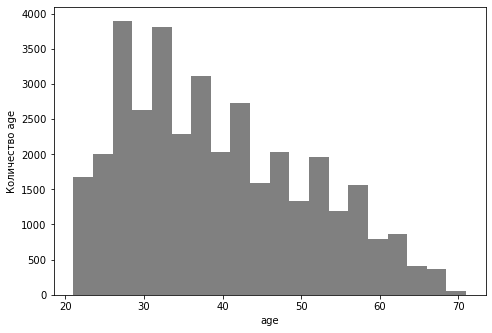

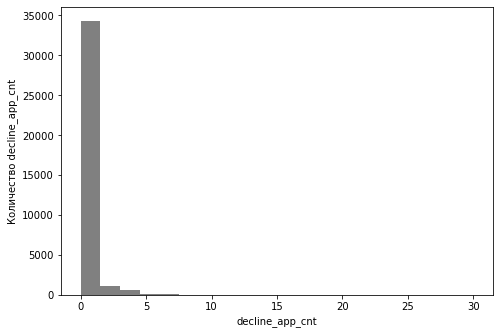

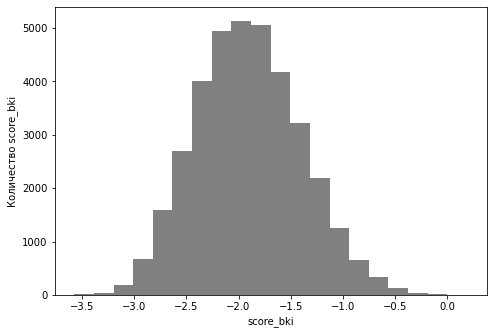

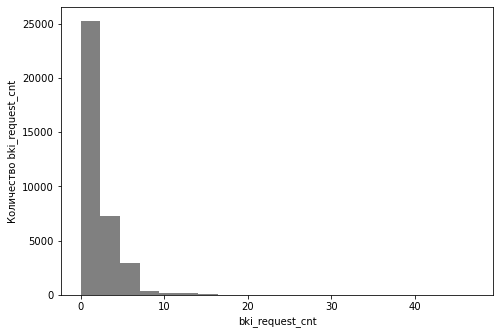

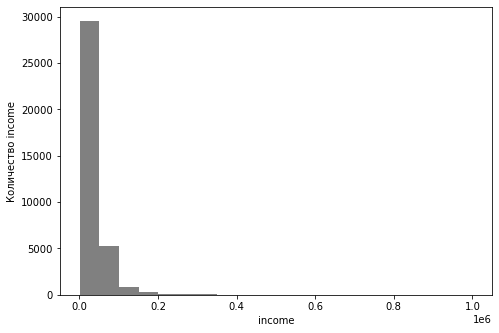

In [21]:
for col in num_cols:
    dist_plot(test, col)

In [22]:
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)

### Построим матрицу корреляций

<AxesSubplot:>

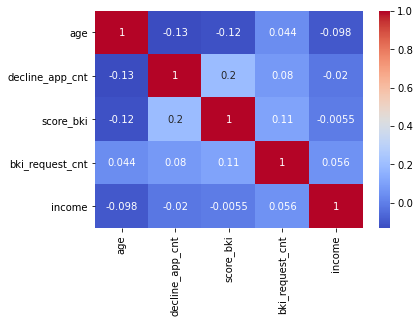

In [23]:
correlation = train[num_cols].corr()
# print(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Наблюдается небольшая корреляция между переменными decline_app_cnt и score_bki

## Рассмотрим бинарные и категориальные переменные

### Закодируем бинарные переменные в 0 и 1

In [24]:
le = LabelEncoder()
for col in bin_cols:
    train[col]=le.fit_transform(train[col])
    test[col]=le.transform(test[col])

In [25]:
display(train.head())
display(test.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1
3,26883,2014-02-03,SCH,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0
4,28862,2014-02-04,GRD,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0


### Избавимся от oversampling при помощи добавления данных

In [32]:
# попробуем oversampling для устранения дисбаланса
train_0 = train[train['default']==0]
train_1 = train[train['default']==1]
koeff = int(len(train_0)/len(train_1))
for i in range(koeff):
    train = train.append(train_1).reset_index(drop=True)

### Преобразуем категориальные переменные при помощи OneHotEncoder

In [33]:
ohe = OneHotEncoder(categories = "auto",sparse = False)

In [34]:
train_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)
test_cat = OneHotEncoder(sparse=False).fit_transform(test[cat_cols].values)

### Стандартизируем числовые переменные

In [39]:
X_num_train = StandardScaler().fit_transform(train[num_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values)

### Сформируем обработанные датасеты

In [43]:
# Объединяем
X = np.hstack([X_num_train, train[bin_cols].values, train_cat])
Y = train['default'].values

In [44]:
test_client_id = test['client_id']
test = np.hstack([X_num_test, test[bin_cols].values, test_cat])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### Обучим модель

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

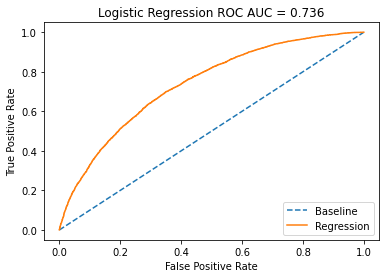

In [46]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [47]:
probs = model.predict_proba(test)
probs = probs[:, 1]

### Cформируем submission

In [48]:
my_submission = pd.DataFrame({'client_id': test_client_id,
                              'default': probs})
my_submission.to_csv('submission.csv', index=False)